### **Conformal Prediction according to Slant Distance**

First lets try to established a correlation between the size of the bounded boxes and the slant_distance, to see if the box area is easily predictible from the slant distance. 

In [33]:
import os
import pandas as pd
import numpy as np


def calculate_polygon_area(x_A, y_A, x_B, y_B, x_C, y_C, x_D, y_D):
    return 0.5 * abs(
        x_A*y_B + x_B*y_C + x_C*y_D + x_D*y_A 
        - (y_A*x_B + y_B*x_C + y_C*x_D + y_D*x_A)
    )

# Normalize coordinates for each corner (instead of the bounding box center)
def normalize_coordinates(x_A, y_A, x_B, y_B, x_C, y_C, x_D, y_D, image_width, image_height):
    # Normalize coordinates to [0, 1]
    x_A_norm = x_A / image_width
    y_A_norm = y_A / image_height
    x_B_norm = x_B / image_width
    y_B_norm = y_B / image_height
    x_C_norm = x_C / image_width
    y_C_norm = y_C / image_height
    x_D_norm = x_D / image_width
    y_D_norm = y_D / image_height
    
    return x_A_norm, y_A_norm, x_B_norm, y_B_norm, x_C_norm, y_C_norm, x_D_norm, y_D_norm

In [34]:
def get_all_slant_bbox_size(folder_path, output_csv="output.csv"): 
    data_list = []
    slant_distances = []  # list to store slant distances for mean and std calculation
    seen_entries = set()  # to track unique entries

    # first pass: collect slant distances
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, sep=";")

            if "slant_distance" in df.columns and df["slant_distance"].notna().any():
                for _, row in df.iterrows():
                    if pd.notna(row.get("slant_distance")):
                        slant_distance_km = row["slant_distance"] * 1.852  # convert to km
                        slant_distances.append(slant_distance_km)

    # Calculate mean and std of slant distances
    mean_slant_distance = np.mean(slant_distances)
    std_slant_distance = np.std(slant_distances)

    # second pass: process files and calculate bbox area
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, sep=";")

            if "slant_distance" in df.columns: #and df["slant_distance"].notna().any()
                for _, row in df.iterrows():
                    #if pd.notna(row.get("slant_distance")):
                        image_name = os.path.basename(row["image"])

                        # create a unique key for the entry
                        entry_key = (image_name, row["x_A"], row["y_A"], row["x_B"], row["y_B"], row["x_C"], row["y_C"], row["x_D"], row["y_D"])

                        # check if the entry has already been processed
                        if entry_key not in seen_entries:
                            # marked as seen
                            seen_entries.add(entry_key)

                            # normalization
                            x_A, y_A = row["x_A"], row["y_A"]
                            x_B, y_B = row["x_B"], row["y_B"]
                            x_C, y_C = row["x_C"], row["y_C"]
                            x_D, y_D = row["x_D"], row["y_D"]
                            image_width = row["width"]  
                            image_height = row["height"]

                            time_to_landing =  row["time_to_landing"]  
                            
                            
                            x_A_norm, y_A_norm, x_B_norm, y_B_norm, x_C_norm, y_C_norm, x_D_norm, y_D_norm = normalize_coordinates(x_A, y_A, x_B, y_B, x_C, y_C, x_D, y_D, image_width, image_height)
                            
                            # calculate bounding box area
                            bbox_area = calculate_polygon_area(x_A, y_A, x_B, y_B, x_C, y_C, x_D, y_D)
                            
                            # convert slant distance to km
                            slant_distance_km = row["slant_distance"] * 1.852  # Conversion en kilomètres
                        
                            # normalize slant distance as z-score
                            slant_distance_zscore = (slant_distance_km - mean_slant_distance) / std_slant_distance

                            # append data to list
                            data_list.append([image_name, slant_distance_km, slant_distance_zscore, time_to_landing, bbox_area, x_A, y_A, x_B, y_B, x_C, y_C, x_D, y_D, x_A_norm, y_A_norm, x_B_norm, y_B_norm, x_C_norm, y_C_norm, x_D_norm, y_D_norm, file])
    
    # convert list to DataFrame and save to CSV
    output_df = pd.DataFrame(data_list, columns=["image", "slant_distance", "slant_distance_zscore","time_to_landing", "bbox_area", "x_A", "y_A", "x_B", "y_B", "x_C", "y_C", "x_D", "y_D", "x_A_norm", "y_A_norm", "x_B_norm", "y_B_norm", "x_C_norm", "y_C_norm", "x_D_norm", "y_D_norm", 'file'])
    output_df.to_csv(output_csv, index=False)
    print(f"Results saved in : {output_csv}")
    
    return output_df


In [35]:
get_all_slant_bbox_size("/home/aws_install/conformal_prediction/csv_test")

Results saved in : output.csv


,image,slant_distance,slant_distance_zscore,time_to_landing,bbox_area,x_A,y_A,x_B,y_B,x_C,...,y_D,x_A_norm,y_A_norm,x_B_norm,y_B_norm,x_C_norm,y_C_norm,x_D_norm,y_D_norm,file
0,0fiHJrxfJPE_KSFO35.png,NaN,NaN,40.0,1080.0,1759,958,1775,958,1745,...,1030,0.458073,0.443519,0.462240,0.443519,0.454427,0.476852,0.466406,0.476852,LARD_test_real_domain_adaptation.csv
1,0fiHJrxfJPE_KSFO37.png,NaN,NaN,25.0,1967.0,1782,945,1759,946,1806,...,1032,0.464062,0.437500,0.458073,0.437963,0.470313,0.476852,0.452344,0.477778,LARD_test_real_domain_adaptation.csv
2,0fiHJrxfJPE_KSFO39.png,NaN,NaN,15.0,6280.0,1792,919,1820,919,1740,...,1038,0.466667,0.425463,0.473958,0.425463,0.453125,0.480093,0.488021,0.480556,LARD_test_real_domain_adaptation.csv
3,17MUtbOfdNQ_LICJ36.png,NaN,NaN,17.0,3782.5,2087,854,2118,855,2039,...,954,0.543490,0.395370,0.551562,0.395833,0.530990,0.440278,0.559115,0.441667,LARD_test_real_domain_adaptation.csv
4,17MUtbOfdNQ_LICJ38.png,NaN,NaN,7.0,23125.5,2063,857,2109,858,1910,...,1029,0.537240,0.396759,0.549219,0.397222,0.497396,0.471759,0.581510,0.476389,LARD_test_real_domain_adaptation.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,ZBAA_36R_35_27.jpeg,0.77784,-0.994957,NaN,25216.0,1489,1404,1448,1405,1428,...,1655,0.608252,0.530211,0.591503,0.530589,0.583333,0.623112,0.482435,0.625000,LARD_test_synth.csv
2311,ZBAA_36R_35_28.jpeg,0.59264,-1.121159,NaN,28445.0,1445,1219,1402,1221,1702,...,1421,0.590278,0.460347,0.572712,0.461103,0.695261,0.529456,0.560458,0.536631,LARD_test_synth.csv
2312,ZBAA_36R_35_29.jpeg,0.57412,-1.133779,NaN,38417.5,969,1013,1012,1018,727,...,1283,0.395833,0.382553,0.413399,0.384441,0.296977,0.469789,0.435866,0.484517,LARD_test_synth.csv
2313,ZBAA_36R_35_30.jpeg,0.50004,-1.184260,NaN,50556.0,1011,1073,1055,1075,770,...,1375,0.412990,0.405211,0.430964,0.405967,0.314542,0.516239,0.470997,0.519260,LARD_test_synth.csv


                    image  slant_distance  slant_distance_zscore  \
0  0fiHJrxfJPE_KSFO35.png             NaN                    NaN   
1  0fiHJrxfJPE_KSFO37.png             NaN                    NaN   
2  0fiHJrxfJPE_KSFO39.png             NaN                    NaN   
3  17MUtbOfdNQ_LICJ36.png             NaN                    NaN   
4  17MUtbOfdNQ_LICJ38.png             NaN                    NaN   

   time_to_landing  bbox_area   x_A  y_A   x_B  y_B   x_C  ...   y_D  \
0             40.0     1080.0  1759  958  1775  958  1745  ...  1030   
1             25.0     1967.0  1782  945  1759  946  1806  ...  1032   
2             15.0     6280.0  1792  919  1820  919  1740  ...  1038   
3             17.0     3782.5  2087  854  2118  855  2039  ...   954   
4              7.0    23125.5  2063  857  2109  858  1910  ...  1029   

   x_A_norm  y_A_norm  x_B_norm  y_B_norm  x_C_norm  y_C_norm  x_D_norm  \
0  0.458073  0.443519  0.462240  0.443519  0.454427  0.476852  0.466406   
1  0.464

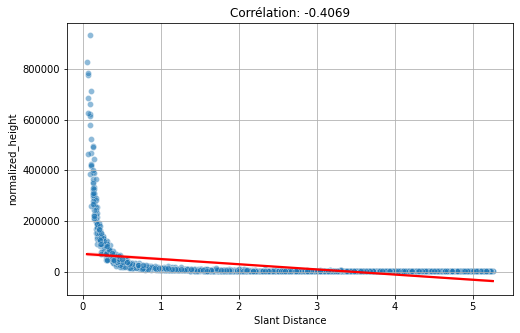

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


df = pd.read_csv("all_test_with_real.csv")

print(df.head())

df = df.dropna(subset=["slant_distance", "bbox_area"])

corr, p_value = pearsonr(df["slant_distance"], df["bbox_area"])

print(f"Coefficient de corrélation de Pearson: {corr:.4f}")
print(f"P-value: {p_value:.4f}")


plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["slant_distance"], y=df["bbox_area"], alpha=0.5)

sns.regplot(x=df["slant_distance"], y=df["bbox_area"], scatter=False, color='red')

plt.xlabel("Slant Distance")
plt.ylabel("normalized_height")
plt.title(f"Corrélation: {corr:.4f}")
plt.grid(True)
plt.show()


Relation négative (donc au fur et à mesure que la slant_distance augment l'aire de la boite a tendance à diminuer), mais la relation est pas linéaire (plus exponentielle d'ailleurs ?)

Pearson correlation: -0.4069
P-value: 0.0000


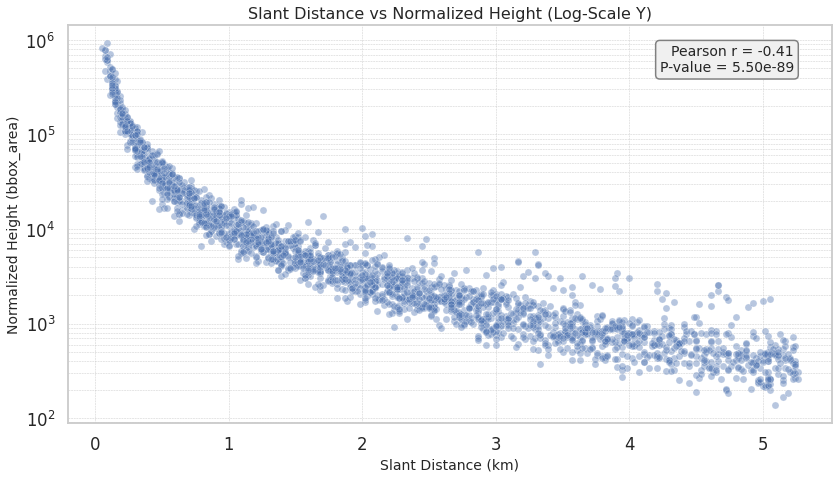

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

df = pd.read_csv("all_test_with_real.csv")
df = df.dropna(subset=["slant_distance", "bbox_area"])

# Pearson correlation
corr, p_value = pearsonr(df["slant_distance"], df["bbox_area"])
print(f"Pearson correlation: {corr:.4f}")
print(f"P-value: {p_value:.4f}")

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(12, 7))

sns.scatterplot(
    x="slant_distance",
    y="bbox_area",
    data=df,
    alpha=0.4,
    edgecolor="w",
    s=50
)

# Optional: regression line
# sns.regplot(
#     x="slant_distance",
#     y="bbox_area",
#     data=df,
#     scatter=False,
#     color="crimson",
#     line_kws={"linewidth": 2}
# )

plt.yscale("log")

plt.xlabel("Slant Distance (km)", fontsize=14)
plt.ylabel("Normalized Height (bbox_area)", fontsize=14)
plt.title("Slant Distance vs Normalized Height (Log-Scale Y)", fontsize=16)


plt.text(
    0.95, 0.95,
    f"Pearson r = {corr:.2f}\nP-value = {p_value:.2e}",
    transform=plt.gca().transAxes,
    fontsize=14,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="#f0f0f0", edgecolor="gray")
)


# Grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Save and show
plt.tight_layout()
plt.savefig("correlation.png", dpi=300)
plt.show()
